# Load packages

In [1]:
from pathlib import Path
project_root = Path("/home/yangk/intership_2025_COSYS")

In [2]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import json
import numpy as np

In [3]:
import sys

sys.path.append(str(project_root / "resource/DexiNed"))
sys.path.append(str(project_root / "src"))

from model import DexiNed
from dataset import BIPEDv2, transforms

# Prepare

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epoch = 50
batch_size = 8
learning_rate = 1e-4
biped_dataset = BIPEDv2(
    project_root / "data/BIPEDv2/BIPED/edges/imgs/train/rgbr/real/",
    project_root / "data/BIPEDv2/BIPED/edges/edge_maps/train/rgbr/real/"
)
# test set
test_dataset = BIPEDv2(
    project_root / "data/BIPEDv2/BIPED/edges/imgs/test/rgbr/",
    project_root / "data/BIPEDv2/BIPED/edges/edge_maps/test/rgbr/"
)

model = DexiNed()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loader = DataLoader(biped_dataset, batch_size=8)
val_loader = DataLoader(test_dataset, batch_size=8)
logging = {
    'metadata': {},
    'train_loss': [],
    'val_loss': []
}


print(device)

cuda


# Train or load

In [83]:
import os
# set checkpoint file name
# file_stem = "cpt_visibility_06"
logging['metadata'] = {
    "description": "re-train", 
    "num_epoch":epoch, 
    "batch_size":batch_size, 
    "criterion": criterion.__class__.__name__, 
    "learning_rate": learning_rate
}

prefix = project_root / "data/checkpoints/torch_point12"
model_path = prefix / "model.pth"
log_path = prefix / "log.json"

# if not os.path.isfile(str(prefix / f"{file_stem}.json")): # First train
if not prefix.is_dir(): # First train
    prefix.mkdir()
    model = model.to(device)
    for e in range(epoch):
        # train step
        model.train()
        epoche_loss = []
        for batch in loader:
            x, y = batch['image_tensor'], batch['visibility_map']
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = sum([criterion(output.squeeze(), y) for output in outputs]) / len(outputs)
            loss.backward()
            optimizer.step()
            print("*", end="", flush=True)
            epoche_loss.append(loss.detach().item())
        logging['train_loss'].append(np.mean(epoche_loss))
        print(f"\nIn epoch {e}, the average  training  loss is {logging['train_loss'][-1]}")
        # validation step
        model.eval()
        val_epoch_loss = []
        with torch.no_grad():
            for batch in val_loader:
                x, y = batch['image_tensor'], batch['visibility_map']
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = sum([criterion(output.squeeze(), y) for output in outputs]) / len(outputs)
                val_epoch_loss.append(loss.detach().item())
        logging['val_loss'].append(np.mean(val_epoch_loss))
        print(f"In epoch {e}, the average validation loss is {logging['val_loss'][-1]}")
    model = model.to('cpu')
    # save files
    # file_stem = "cpt_visibility_01"
    torch.save(model.state_dict(), str(model_path))
    print(f"Succeed saving mdoel parameters in {model_path}.")
    with open(str(log_path), "w") as f:
        json.dump(logging, f)
    print(f"Succeed saving log in {log_path}.")
else: # already trained
    # load model
    model.load_state_dict(torch.load(str(model_path), weights_only=True))
    # # load log
    with open(str(log_path), 'r') as f:
        logging = json.load(f)
    # # print the loss
    for e, (train_loss, val_loss) in enumerate(zip(logging['train_loss'], logging['val_loss'])):
        print("-".join(["-"]*30))
        print(f"In epoch {e}, the average  training  loss is {train_loss}")
        print(f"In epoch {e}, the average validation loss is {val_loss}")

-----------------------------------------------------------
In epoch 0, the average  training  loss is 213.89327453613282
In epoch 0, the average validation loss is 226.48939187186105
-----------------------------------------------------------
In epoch 1, the average  training  loss is 211.26926452636718
In epoch 1, the average validation loss is 222.89054216657365
-----------------------------------------------------------
In epoch 2, the average  training  loss is 209.7284094238281
In epoch 2, the average validation loss is 221.98137773786272
-----------------------------------------------------------
In epoch 3, the average  training  loss is 208.71645599365235
In epoch 3, the average validation loss is 220.54527500697546
-----------------------------------------------------------
In epoch 4, the average  training  loss is 207.81862182617186
In epoch 4, the average validation loss is 219.41571698869978
-----------------------------------------------------------
In epoch 5, the avera

# Result

In [84]:
from PIL import Image
# take one example
item= biped_dataset.__getitem__(6)
img, x, y = Image.open(item['image_path']).convert('RGB'), item['image_tensor'], item['visibility_map'] # item['edge_tensor']
# x = biped_dataset.transform(img)
# inference
model.eval()
with torch.no_grad():
    model.to(device)
    yhat = model(x.unsqueeze(0).to(device))[-1].squeeze()
    yhat = yhat.to('cpu')
    model.to('cpu')

{'description': 'GT with mean blur', 'num_epoch': 100, 'criterion': 'WeightedMSELossWithMeanBlur', 'batch_size': 8, 'learning_rate': 5e-05}


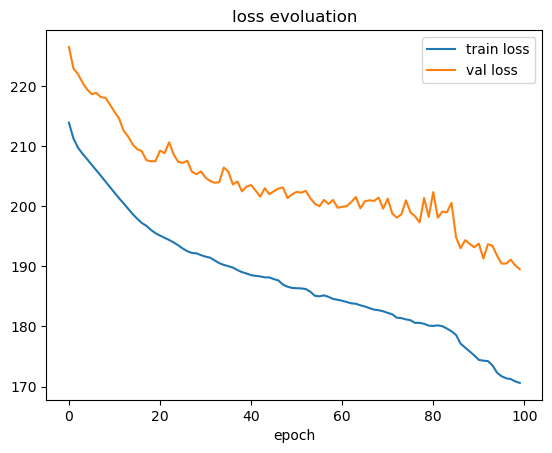

In [85]:
import matplotlib.pyplot as plt
print(logging['metadata'])
# Loss
plt.plot(logging['train_loss'], label="train loss")
plt.plot(logging['val_loss'], label="val loss")
plt.xlabel("epoch")
plt.title("loss evoluation")
plt.legend()
plt.show()

In [86]:
# NMS
from nms import get_gradient_canny, nms_fully_vectorized

gx, gy = get_gradient_canny(x.mean(dim=0))
edge_map = nms_fully_vectorized(yhat, gx, gy)

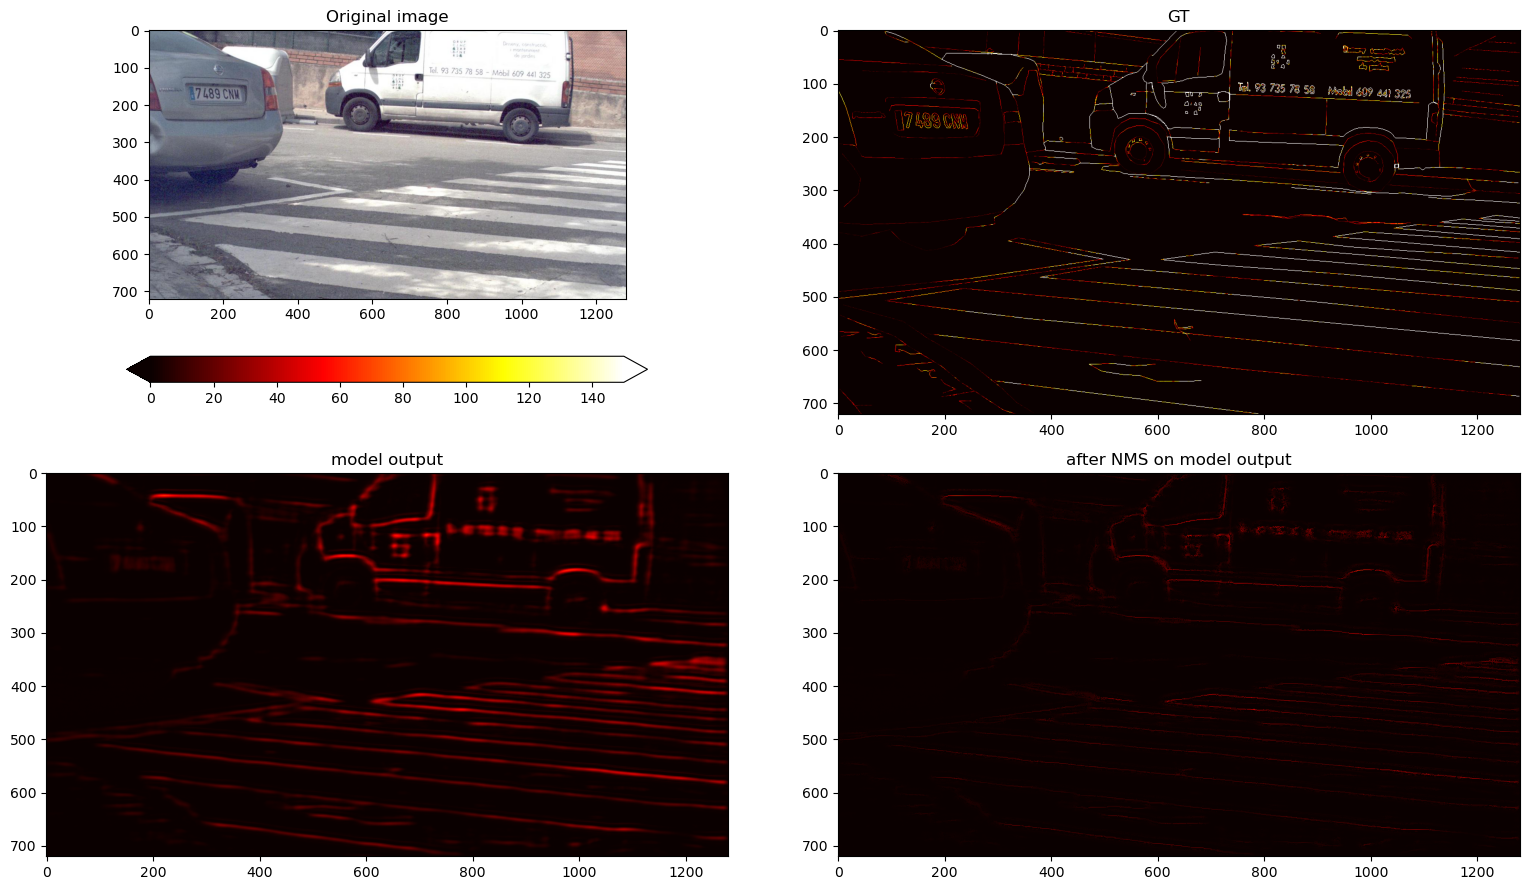

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# edge
def normalisation(img, denom=80):
    res = img / denom
    res = np.where(res<0, 0, res)
    res = np.where(res>1, 1, res) 
    return res

cmap_type="hot" # plasma, inferno, hot, seismic
vmin, vmax = 0, 150

# display
fig, axes = plt.subplots(2, 2, figsize=(16, 9))

# Loss
# axes[0,0].plot(logging['train_loss'])
# axes[0,0].plot(logging['val_loss'])
# axes[0,0].set_xlabel("epoch")
# axes[0,0].set_title("Epoch Loss")

# original image
axes[0,0].imshow(img)
axes[0,0].set_title("Original image")
# axes[0,1].axis('off')  # 不显示坐标轴

im = axes[0,1].imshow(y, cmap=cmap_type, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[0,0], shrink=0.7, location='bottom', extend='both')
axes[0,1].set_title("GT")
# axes[1,1].axis('off')  # 不显示坐标轴

axes[1,0].imshow(yhat, cmap=cmap_type, vmin=vmin, vmax=vmax)
# axes[1,0].imshow(normalisation(yhat, 80), cmap="gray")
axes[1,0].set_title("model output")
# axes[1,1].axis('off')  # 不显示坐标轴

axes[1,1].imshow(edge_map, cmap=cmap_type, vmin=vmin, vmax=vmax)
axes[1,1].set_title("after NMS on model output")
# axes[1,0].axis('off')  # 不显示坐标轴

plt.tight_layout()  # 自动调整子图间距
plt.show()

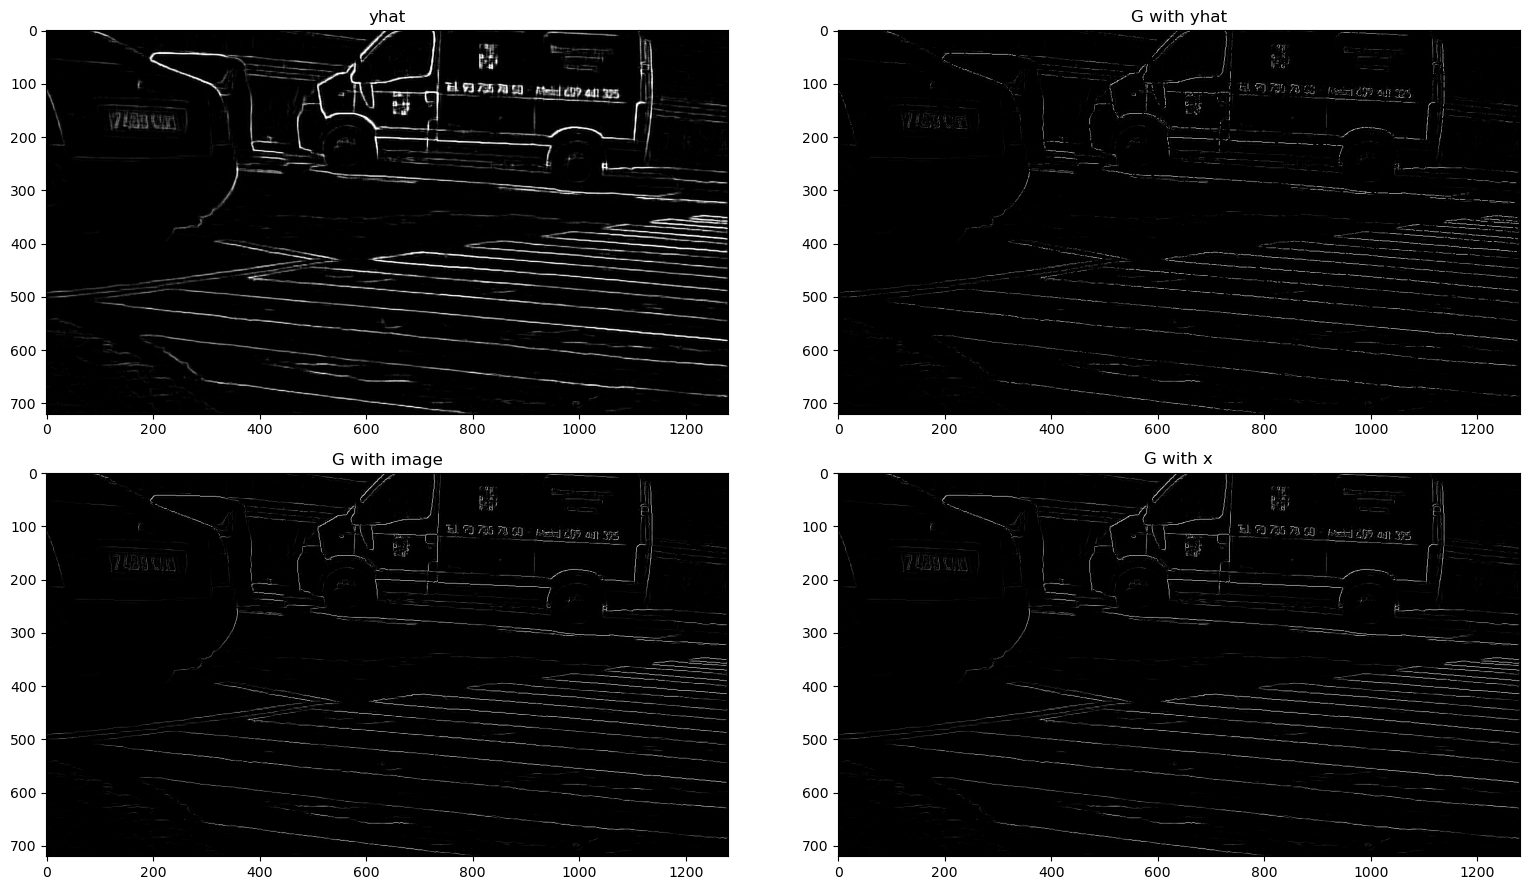

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# display
fig, axes = plt.subplots(2, 2, figsize=(16, 9))

# Loss
axes[0,0].imshow(normalisation(yhat, 80), cmap="gray")
axes[0,0].set_title("yhat")

gx, gy = get_gradient_canny(yhat)
nms_edge = nms_fully_vectorized(yhat, gx, gy)
axes[0,1].imshow(normalisation(nms_edge, 80), cmap="gray")
axes[0,1].set_title("G with yhat")

gx, gy = get_gradient_canny(transforms.ToTensor()(img.convert("L")).squeeze())
nms_edge = nms_fully_vectorized(yhat, gx, gy)
axes[1,0].imshow(normalisation(nms_edge, 80), cmap="gray")
axes[1,0].set_title("G with image")

gx, gy = get_gradient_canny(x.mean(dim=0))
nms_edge = nms_fully_vectorized(yhat, gx, gy)
axes[1,1].imshow(normalisation(nms_edge, 80), cmap="gray")
axes[1,1].set_title("G with x")

plt.tight_layout()  # 自动调整子图间距
plt.show()